## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import random
%matplotlib inline

In [3]:
from tensorflow import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling2D, Reshape
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.utils import plot_model

## Exploring Dataset

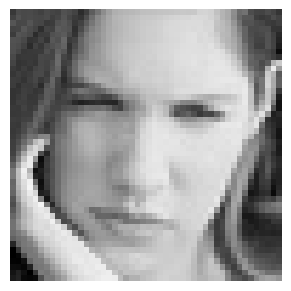

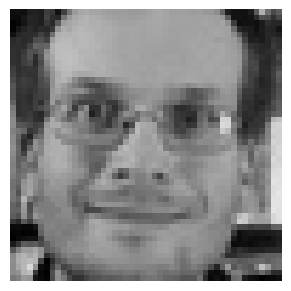

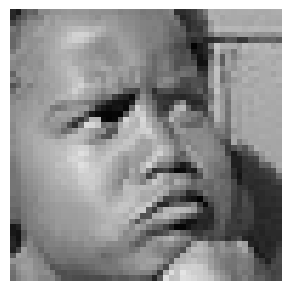

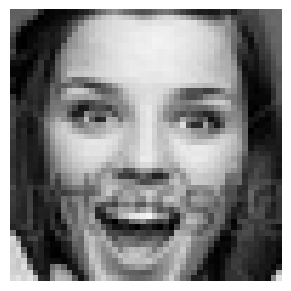

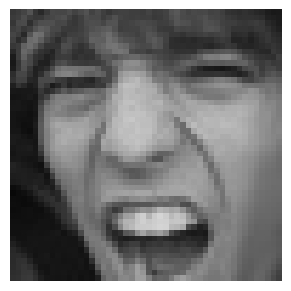

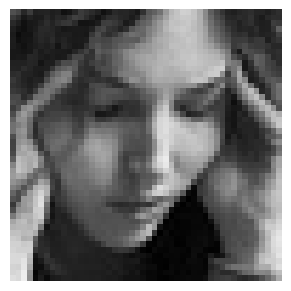

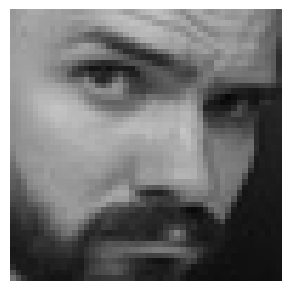

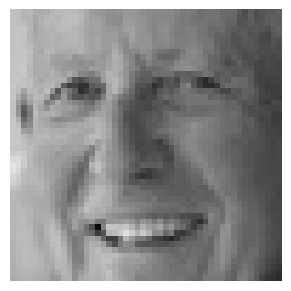

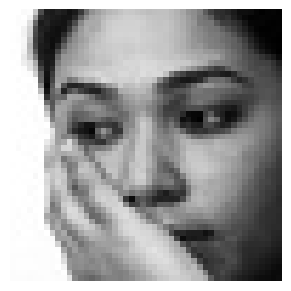

In [4]:
images = glob("train/**/**")
for i in range(9):
    image =random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [5]:
img_size = 48
batch_size = 64
sequence_length = 5

datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = datagen_train.flow_from_directory('train/',
                                                    target_size=(img_size,img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory('test/',
                                                              target_size=(img_size,img_size),
                                                              color_mode='grayscale',
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
def generate_sequence_data(generator, sequence_length):
    while True:
        batch_x, batch_y = next(generator)
        sequence_x = []
        sequence_y = []
        for i in range(len(batch_x)-sequence_length+1):
            sequence_x.append(batch_x[i:i+sequence_length])
            sequence_y.append(batch_y[i+sequence_length-1])
        yield np.array(sequence_x), np.array(sequence_y)

## Preparing Training and Validation data sequence

In [7]:
train_sequence_generator = generate_sequence_data(train_generator,sequence_length)
validation_sequence_generator = generate_sequence_data(validation_generator, sequence_length)

In [8]:
def create_sequential_model(input_shape, sequence_length):
    model = Sequential()
    
    model.add(Reshape((sequence_length, -1), input_shape=(sequence_length,) + input_shape))
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(LSTM(units=256, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [9]:
input_shape = (48, 48, 1)
sequence_length = 5

In [10]:
sequential_model = create_sequential_model(input_shape, sequence_length)
sequential_model.summary()

c:\Users\SHAIK\Desktop\PROJECT\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 5, 2304)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 64)          │       606,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,487 (4.72 MB)

 Trainable params: 1,235,591 (4.71 MB)

 Non-trainable params: 896 (3.50 KB)

## Initializing the Model

In [11]:
epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
callbacks = [checkpoint, reduce_lr]

## Training the Model

In [12]:
history = sequential_model.fit(train_sequence_generator,
                               steps_per_epoch=steps_per_epoch,
                               epochs=epochs,
                               validation_data = validation_sequence_generator,
                               validation_steps = validation_steps,
                               callbacks = callbacks)

Epoch 1/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.2251 - loss: 1.8572
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 385s 840ms/step - accuracy: 0.2251 - loss: 1.8571 - val_accuracy: 0.2476 - val_loss: 1.8089 - learning_rate: 0.0010
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2723 - loss: 1.7695
Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 0.2723 - loss: 1.7694 - val_accuracy: 0.2114 - val_loss: 1.8904 - learning_rate: 0.0010
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2854 - loss: 1.7627
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 65s 145ms/step - accuracy: 0.2855 - loss: 1.7627 - val_accuracy: 0.1745 - val_loss: 1.8883 - learning_rate: 0.0010
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2889 - loss: 1.7560
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━

In [13]:
batch_size = 64  
evaluation_steps = len(validation_generator)
evaluation_results = sequential_model.evaluate(validation_sequence_generator, steps=evaluation_steps, batch_size=batch_size)


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.3391 - loss: 1.7009


## Loss Plot

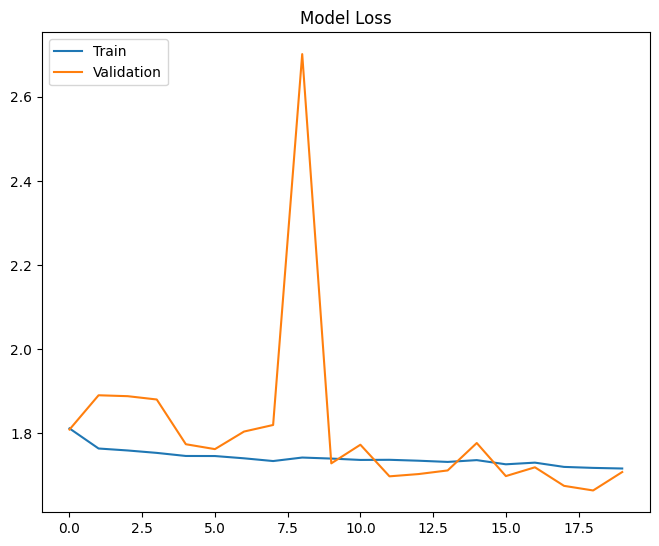

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

## Accuracy Plot

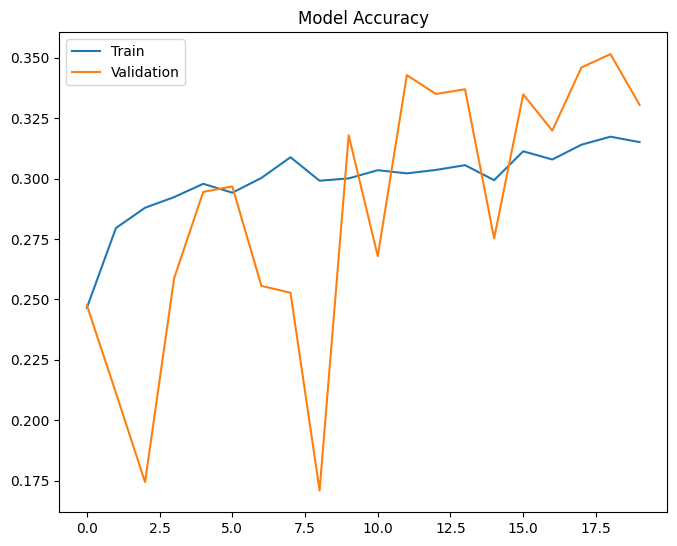

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

## Saving the Model

In [16]:
model_json = sequential_model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)